In [385]:
%run data_preprocessing.ipynb

19
10
13
18
20
21
9
{0: [13, 7, 13, 14, 13, 10, 5, 4, 3, 2, 2, 0, 4, 12, 13, 14, 5, 3, 10, 9, 14, 10, 1, 2, 4, 7, 26, 4, 12, 12, 23, 22, 27, 10, 12, 17, 44, 3, 4, 19, 7, 16, 9, 42, 57, 14, 14, 18, 17, 16, 18, 23, 4, 19, 5, 2, 18, 8, 6, 6, 3, 5, 4, 4, 4, 4, 9, 21, 19, 5, 19, 16, 33, 11, 11, 11, 66, 11, 15, 5, 13, 14, 4, 4, 3, 1, 3, 1, 3, 2, 4, 1, 0, 21, 20, 20, 20, 39, 12, 11, 5, 4, 22, 13, 13, 13, 15, 8, 11, 8, 12, 16, 16, 7, 4, 5, 4, 5, 5, 6, 2, 3, 7, 14, 16, 8, 8, 14, 8, 10, 11, 9, 150, 9, 7, 10, 14, 12, 166, 6, 5, 11, 1, 5, 6, 7, 4, 1, 2, 2, 1, 6, 0, 16, 14, 9, 19, 11, 8, 9, 21, 33, 31, 30, 65, 73, 45, 64, 61, 90, 66, 51, 26, 15, 22, 20, 12, 7, 7, 10, 8, 8, 99, 59, 55, 43, 21, 14, 21, 26, 25, 26, 26, 38, 38, 35, 24, 15, 14, 18, 11, 12, 11, 8, 17, 16, 21, 12, 8, 20, 47, 66, 51, 67, 46, 48, 11, 14, 12, 18, 15, 25, 20, 17, 24, 15, 20, 16, 17, 11, 9, 16, 15, 12, 14, 17, 20, 18, 16, 14, 17, 14, 65, 63, 37, 57, 44, 28, 9, 5, 7, 5, 8, 5, 6, 5, 11, 10, 9, 6, 7, 10, 11, 10, 8, 0, 5, 6, 9, 7,

[([13, 7, 13, 14, 13, 10, 5, 4, 3, 2], (0, 0, 0)), ([7, 13, 14, 13, 10, 5, 4, 3, 2, 2], (0, 4, 0)), ([13, 14, 13, 10, 5, 4, 3, 2, 2, 0], (0, 12, 1)), ([14, 13, 10, 5, 4, 3, 2, 2, 0, 4], (0, 13, 1)), ([13, 10, 5, 4, 3, 2, 2, 0, 4, 12], (0, 14, 1)), ([10, 5, 4, 3, 2, 2, 0, 4, 12, 13], (0, 5, 0)), ([5, 4, 3, 2, 2, 0, 4, 12, 13, 14], (0, 3, 0)), ([4, 3, 2, 2, 0, 4, 12, 13, 14, 5], (0, 10, 1)), ([3, 2, 2, 0, 4, 12, 13, 14, 5, 3], (0, 9, 1)), ([2, 2, 0, 4, 12, 13, 14, 5, 3, 10], (0, 14, 1)), ([2, 0, 4, 12, 13, 14, 5, 3, 10, 9], (0, 10, 1)), ([0, 4, 12, 13, 14, 5, 3, 10, 9, 14], (0, 1, 0)), ([4, 12, 13, 14, 5, 3, 10, 9, 14, 10], (0, 2, 0)), ([12, 13, 14, 5, 3, 10, 9, 14, 10, 1], (0, 4, 0)), ([13, 14, 5, 3, 10, 9, 14, 10, 1, 2], (0, 7, 1)), ([14, 5, 3, 10, 9, 14, 10, 1, 2, 4], (0, 26, 2)), ([5, 3, 10, 9, 14, 10, 1, 2, 4, 7], (0, 4, 0)), ([3, 10, 9, 14, 10, 1, 2, 4, 7, 26], (0, 12, 1)), ([10, 9, 14, 10, 1, 2, 4, 7, 26, 4], (0, 12, 1)), ([9, 14, 10, 1, 2, 4, 7, 26, 4, 12], (0, 23, 2)), ([14, 10,

[([833.0, 2806.0, 6484.0, 6839.0], (1, 312.0, 2)), ([2806.0, 6484.0, 6839.0, 0.0], (1, 87.0, 1)), ([6484.0, 6839.0, 0.0, 312.0], (1, 67.0, 1)), ([6839.0, 0.0, 312.0, 87.0], (1, 52.0, 1)), ([0.0, 312.0, 87.0, 67.0], (1, 41.0, 1)), ([312.0, 87.0, 67.0, 52.0], (1, 25.0, 1)), ([87.0, 67.0, 52.0, 41.0], (1, 325.0, 2)), ([67.0, 52.0, 41.0, 25.0], (1, 1166.0, 2)), ([52.0, 41.0, 25.0, 325.0], (1, 3659.0, 2)), ([41.0, 25.0, 325.0, 1166.0], (1, 14591.0, 2)), ([25.0, 325.0, 1166.0, 3659.0], (1, 4546.0, 2)), ([325.0, 1166.0, 3659.0, 14591.0], (1, 314.0, 2)), ([1166.0, 3659.0, 14591.0, 4546.0], (1, 374.0, 2)), ([3659.0, 14591.0, 4546.0, 314.0], (1, 86.0, 1)), ([14591.0, 4546.0, 314.0, 374.0], (1, 68.0, 1)), ([4546.0, 314.0, 374.0, 86.0], (1, 69.0, 1)), ([314.0, 374.0, 86.0, 68.0], (1, 0.0, 0)), ([374.0, 86.0, 68.0, 69.0], (1, 0.0, 0)), ([86.0, 68.0, 69.0, 0.0], (1, 512.0, 2)), ([68.0, 69.0, 0.0, 0.0], (1, 1041.0, 2)), ([69.0, 0.0, 0.0, 512.0], (1, 2136.0, 2)), ([0.0, 0.0, 512.0, 1041.0], (1, 4003.0

In [415]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from math import sqrt
from fbprophet import Prophet 
from fbprophet.plot import add_changepoints_to_plot
import math
import pmdarima as pm
from scipy import stats
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer
from scipy.special import inv_boxcox
from sklearn.model_selection import ParameterGrid
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from bayes_opt import BayesianOptimization
import epysurv

ModuleNotFoundError: No module named 'epysurv'

### Combining Auto Arima with Prophet
Results
1. Auto-Arima achieved 68% accuracy rate when predicting the states of the next two months
2. Combined with prophet, achieves around 67-77% accuracy (best recorded 79% accuracy)

In [398]:
country_monthly_thresholds = monthly_thresholds[12]
def compare_predicted_state_to_ground_truth(predicted_no_cases, ground_truth, threshold=country_monthly_thresholds):
    predicted_state = find_state(threshold, predicted_no_cases)
    if predicted_state != ground_truth:
        print("Predicted: {0} Correct: {1}".format(predicted_state, ground_truth))
    return int(predicted_state == ground_truth)

In [399]:
#Testing Autoarima On Monthly Data

#lmbda is the value to add to the training_data to make it non-negative - it's applied manually to the df
#which will be used by prophet and automatically in the pipeline defined by the Auto-Arima model
lmbda=1e-6

month_data_burkina = month_data.loc[month_data["Country"] == 12]

#Apply Box-Cox transformation to prophet data since that is not gonna go through the pipeline of auto_arima
month_data_burkina_prophet = month_data_burkina.copy()

# X_prophet = month_data_burkina_prophet["Cases"].values
# X_prophet = stats.boxcox(X_prophet, lmbda=lmbda)
# prophet fits a more stable model when we plot log(x+1) of the data
std = month_data_burkina_prophet["Cases"].std()
month_data_burkina_prophet["Cases"] = month_data_burkina_prophet["Cases"].apply(lambda x: math.log(x+1))
month_data_burkina_prophet = month_data_burkina_prophet.rename(columns={"Date":"ds", "Cases":"y"})
month_data_burkina_prophet = month_data_burkina_prophet.drop(columns=["State", "Country"])

#Note that we will apply a BoxCox transformation on the data but will integrate it into the pipeline
X = month_data_burkina["Cases"].values
separation = int(len(month_data_burkina) * 0.8)

#note must be numpy arrays
train_data = X[:separation]
test_data = X[separation:]
test_states = month_data_burkina[separation:]["State"]
test_states = test_states.reset_index(drop=True)
burkina_monthly_thresholds = monthly_thresholds[12]
print(monthly_thresholds[1])

[8.2, 236.79999999999987]


In [400]:
class AutoArima():
    def __init__(self):
        self.model = Pipeline([
                        ('boxcox', BoxCoxEndogTransformer(lmbda2=lmbda)),
                        ('arima', pm.AutoARIMA(trace=True,
                                               suppress_warnings=True,
                                               m=12))
                    ])
    def fit(self, train_data):
        self.model.fit(train_data)
        
auto_arima = AutoArima()
auto_arima.fit(train_data)
auto_arima.model.summary()


Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(1,0,1,12) [intercept=True]; AIC=685.236, BIC=708.419, Time=0.636 seconds
Fit ARIMA(0,0,0)x(0,0,0,12) [intercept=True]; AIC=728.414, BIC=734.210, Time=0.008 seconds
Fit ARIMA(1,0,0)x(1,0,0,12) [intercept=True]; AIC=689.511, BIC=701.102, Time=0.092 seconds
Fit ARIMA(0,0,1)x(0,0,1,12) [intercept=True]; AIC=693.720, BIC=705.311, Time=0.072 seconds
Fit ARIMA(0,0,0)x(0,0,0,12) [intercept=False]; AIC=881.723, BIC=884.621, Time=0.006 seconds
Fit ARIMA(2,0,2)x(0,0,1,12) [intercept=True]; AIC=691.498, BIC=711.783, Time=0.486 seconds
Fit ARIMA(2,0,2)x(1,0,0,12) [intercept=True]; AIC=693.785, BIC=714.070, Time=0.381 seconds
Fit ARIMA(2,0,2)x(2,0,1,12) [intercept=True]; AIC=688.081, BIC=714.161, Time=1.408 seconds
Fit ARIMA(2,0,2)x(1,0,2,12) [intercept=True]; AIC=688.867, BIC=714.947, Time=1.357 seconds
Near non-invertible roots for order (2, 0, 2)(1, 0, 2, 12); setting score to inf (at least one inverse root too close to the border of th

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  134
Model:             SARIMAX(3, 0, 2)x(1, 0, [1], 12)   Log Likelihood                -332.101
Date:                              Sun, 31 May 2020   AIC                            682.201
Time:                                      11:31:39   BIC                            708.282
Sample:                                           0   HQIC                           692.800
                                              - 134                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.5611      1.586      0.984      0.325      -1.548       4.670
ar.L1         -0.9059      0.096     -9.412      0.000      -1.095      -0.717
ar.L2         -0.4525      0.109     -4.136      0.000      -0.667      -0.238
ar.L3          0.2019      0.103      1.957      0.050      -0.000       0.404
ma.L1          1.3937      0.298      4.681      0.000       0.810       1.977
ma.L2          0.9933      0.452      2.197      0.028       0.107       1.879
ar.S.L12       0.8676      0.131      6.607      0.000       0.610       1.125
ma.S.L12      -0.6429      0.215     -2.991      0.003      -1.064      -0.222
sigma2         7.8243      3.232      2.421      0.015       1.489      14.159
===================================================================================
Ljung-Box (Q):                       32.51   Jarque-Bera (JB):                33.36
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               0.64   Skew:                            -0.81
Prob(H) (two-sided):                  0.14   Kurtosis:                         4.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Test 1: 
Combining Prophet with Auto-Arima by making a proporitional adjustment to auto-arima prediction based on the predictions of prophet

/Users/amirgirgis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/amirgirgis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/amirgirgis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to b

            ds     trend  cap  floor  yhat_lower  yhat_upper  trend_lower  \
0   2006-01-31  2.916699   12      0    2.104436    4.526772     2.916699   
1   2006-02-28  2.920877   12      0    2.428091    4.844660     2.920877   
2   2006-03-31  2.925507   12      0    3.173652    5.657691     2.925507   
3   2006-04-30  2.929992   12      0    3.148607    5.537188     2.929992   
4   2006-05-31  2.934632   12      0    1.921565    4.338273     2.934632   
..         ...       ...  ...    ...         ...         ...          ...   
161 2019-06-30  4.396717   12      0    2.395834    4.851962     4.396717   
162 2019-07-31  4.411824   12      0    2.664967    5.017134     4.411824   
163 2019-08-31  4.426953   12      0    2.070835    4.576367     4.426953   
164 2019-09-30  4.441615   12      0    2.287997    4.754535     4.441615   
165 2019-10-31  4.456786   12      0    2.042939    4.655123     4.456786   

     trend_upper  additive_terms  additive_terms_lower  ...   monthly  \
0 

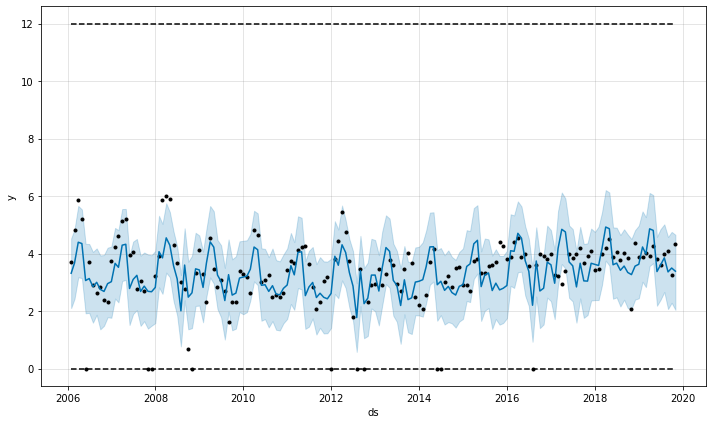

In [401]:
#Before combining Prophet with Auto-Arima, we will see what parameters allow for a good fit on the data
train_prophet = month_data_burkina_prophet[:-2]
train_prophet["floor"] = 0
train_prophet["cap"] = 12
test_prophet = month_data_burkina_prophet[-2:]
test_prophet["floor"] = 0
test_prophet["cap"] = 12

model = Prophet(growth = "logistic", seasonality_mode = "additive", weekly_seasonality=False, \
               changepoint_prior_scale=0.3, yearly_seasonality=False).add_seasonality( 
                                                                    name="monthly",
                                                                    period=30.5,
                                                                    fourier_order=3).add_seasonality(
                                                                    name="yearly",
                                                                    period=365.25,
                                                                    fourier_order=10)

test_prophet = test_prophet.drop(columns=["y"])
test_prophet = test_prophet.reset_index(drop=True)
model.fit(train_prophet)
forecast = model.predict(train_prophet)
fig = model.plot(forecast)
print(forecast)

In [402]:
#A class that will be used to apply statistical significance test at each iteration
#QUESTION: what significance level should the p-value be compared to? Can we make this a learnable parameter?
#Main issue: running this pipeline in parallel with some significance level alpha for our different data streams
#means a false alarm in at least one will be much higher than alpha
class SignificanceTest():
    def __init__(self):
        pass
    
    #previous cases will be the array with the number of cases from previous timesteps
    def calculate_probability_distribution(self, previous_cases):
        sum_cases = sum(previous_cases)
        prob_distribution = previous_cases/sum_cases
        return prob_distribution
    
    #recorded_no_cases is the no_cases at the last most availabe timestep and what the significance level will 
    #determine constitutes a suscpicious peak or not
    #bins has to be quite large since we are going to need to calculate the area thus will increase precision
    def calculate_pvalue(self, prob_distribution, beta=100):
        n, bins, patches = plt.hist(prob_distribution, 
                            bins=beta, 
                            density=True)
        recorded_no_cases = prob_distribution[-1]
        #get bin width
        bin_width = bins[1] - bins[0]
        #the code below will find the index of the first bin value > recorded number of cases
        bin1 = np.searchsorted(bins,recorded_no_cases)
        # sum over number in each bin and mult by bin width, which can be factored out    
        integral = bin_width * sum(n[bin1:])
        return integral
    
    def return_pvalue(self, previous_cases, beta=100):
        prob_distribution = self.calculate_probability_distribution(previous_cases)
        return self.calculate_pvalue(prob_distribution, beta)
    
    #compute an exponentially weighted moving average without a bias correction (since we want to dampen the ewma
    #to not add too large of an adjustment)
    def ewma(self, sequence, beta):
        y_current=(beta*sequence[0])
        for i in range(1, len(sequence)):
            y_current = ((beta*y_current) + (1-beta)*sequence[i])
        return y_current


In [403]:
#a class to handle prophet predicting and fitting which will be used in conjunction with auto_arima
class ProphetTimeStep():
    def __init__(self):
        self.model = None
        self.optimum_parameters = None
    
    #TODO: add features to customize prophet model instantiated
    def instantiate_model(self, growth, seasonality_mode, changepoint_prior_scale, n_changepoints):
        self.model = Prophet(daily_seasonality=False,
                             growth=growth,
                             seasonality_mode=seasonality_mode,
                             changepoint_prior_scale=changepoint_prior_scale).\
                             add_seasonality(name="monthly", period=30.5, fourier_order=3)
                                                                    
    #positional parameters have been changed to the optimum ones found from grid search
    def fit_model(self, df, growth="linear", seasonality_mode="additive", changepoint_prior_scale=0.1,
                         n_changepoints=10):
        model = self.instantiate_model(growth, seasonality_mode, changepoint_prior_scale, n_changepoints)
        self.model.fit(df)
    
    def predict_prophet(self, df, counter):
        df = df[:counter]
        self.fit_model(df)

        future = self.model.make_future_dataframe(2, freq="M")
        forecast = self.model.predict(future)
        #need to inverse the log(x+1) transformation that was applied
        inverse_yhat = forecast["yhat"].apply(lambda x: np.exp(x) + 1)
        inverse_yhat_lower = forecast["yhat_lower"].apply(lambda x: np.exp(x)+1)
        inverse_yhat_upper = forecast["yhat_upper"].apply(lambda x: np.exp(x) + 1)
        forecast["yhat"], forecast["yhat_lower"], forecast["yhat_upper"] = inverse_yhat, inverse_yhat_lower,\
                                                                           inverse_yhat_upper
        return forecast[counter:]
    
    def cross_validate_prophet(self, df):
        df_cv = cross_validation(model, initial="3650 days", period="700 days", horizon="700 days")
        return df_cv
    
    #Note the error terms generated from this are on the log(data) which is why the errors are comparatively 
    #small in magnitude
    def find_optimum_hyperparameters(self):
        params_grid = {'seasonality_mode':('multiplicative','additive'),
                       'changepoint_prior_scale':[0.1,0.3,0.5],
                       'n_changepoints' : [10,20]}
        
        
        grid = ParameterGrid(params_grid)
        model_parameters = pd.DataFrame(columns = ['MAE','Parameters'])
        for p in grid:
            self.fit_model(month_data_burkina_prophet[:separation], seasonality_mode=p['seasonality_mode'])
            df_cv = cross_validation(self.model, initial="1461", period="700 days", horizon="365 days")
            #set rolling window=1 to get only one value for each metric rather than one for each horizon length
            mae = performance_metrics(df_cv, rolling_window=1)["mae"].item()
            print(mae)
            model_parameters = model_parameters.append({'MAE':mae, 'Parameters':p}, ignore_index=True)
        parameters = model_parameters.sort_values(by=['MAE'])
        parameters = parameters.reset_index(drop=True)
        self.optimum_parameters = parameters.loc[0, "Parameters"]
        print('OPTIMUM: ', self.optimum_parameters)
            


In [ ]:
test = ProphetTimeStep()
test.find_optimum_hyperparameters()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


|   iter    |  target   |   alpha   |   beta    |   delta   |   gamma   |    mu     |
-------------------------------------------------------------------------------------
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.671769757699636


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0
Predicted: 2 Correct: 0

>Predicted=[30.72751873 33.1673068 ], Expected=[4 2]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.671769757699636


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0
Predicted: 2 Correct: 1

>Predicted=[32.32254998 33.76625139], Expected=[ 3 10]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.671769757699636


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 1
Predicted: 2 Correct: 0

>Predicted=[30.51390585 47.33634337], Expected=[14  9]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.671769757699636


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0
Predicted: 2 Correct: 1

>Predicted=[19.3978185  53.16175986], Expected=[ 9 13]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.671769757699636


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0
Predicted: 2 Correct: 1

>Predicted=[21.74602023 32.08592237], Expected=[ 9 12]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.671769757699636


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0

>Predicted=[24.44874282 25.98202207], Expected=[ 8 16]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.671769757699636


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 1
Predicted: 2 Correct: 0

>Predicted=[25.15460058 28.49550419], Expected=[14  8]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.671769757699636


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 1 Correct: 2

>Predicted=[14.42447923 44.94745857], Expected=[53 65]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.671769757699636


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.



>Predicted=[26.88681    36.32698958], Expected=[39 50]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.671769757699636


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.



>Predicted=[41.4472702  27.11829429], Expected=[59 30]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.671769757699636


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 1

>Predicted=[41.42422669 28.33742155], Expected=[10 21]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.671769757699636


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0

>Predicted=[18.25599195 40.94678681], Expected=[19  7]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.671769757699636


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 0 Correct: 2
Predicted: 2 Correct: 0

>Predicted=[ 9.2905103  28.40171788], Expected=[17  9]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.671769757699636


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.



>Predicted=[20.74064108 31.23337792], Expected=[20 16]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.671769757699636


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 1

>Predicted=[36.28947473 25.63386061], Expected=[19 11]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.671769757699636


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.



>Predicted=[32.66189654 35.43355853], Expected=[18 24]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.671769757699636


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.



>Predicted=[17.5730498  38.16196391], Expected=[18 19]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.671769757699636


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 1

>Predicted=[13.92511817 25.62860841], Expected=[11 12]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.671769757699636


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0
Predicted: 2 Correct: 1

>Predicted=[21.91847198 15.42166858], Expected=[ 8 11]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.671769757699636


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 1

>Predicted=[32.60363303 29.98841366], Expected=[17 15]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.671769757699636


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0
Predicted: 2 Correct: 0

>Predicted=[22.45548541 35.61835626], Expected=[6 8]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.671769757699636


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.



>Predicted=[16.12390011 33.22848945], Expected=[28 43]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.671769757699636


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.



>Predicted=[26.53047291 23.12679034], Expected=[55 46]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.671769757699636


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0

>Predicted=[32.08068768 20.92460947], Expected=[ 7 79]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.671769757699636


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0

>Predicted=[33.70211666 24.92300893], Expected=[48  9]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.671769757699636


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0
Predicted: 2 Correct: 0

>Predicted=[16.86990908 35.28356687], Expected=[7 9]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.671769757699636


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 1

>Predicted=[14.250657   22.43066702], Expected=[10 13]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.671769757699636


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0

>Predicted=[30.76682373 25.3056787 ], Expected=[23  9]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.671769757699636


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 1
Predicted: 2 Correct: 1

>Predicted=[26.93252972 27.39737304], Expected=[13 10]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.671769757699636


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0

>Predicted=[11.70205186 35.01828761], Expected=[11  5]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.671769757699636


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 1 Correct: 2
Predicted: 2 Correct: 1

>Predicted=[10.89235098 19.19420651], Expected=[21 13]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.671769757699636


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0
Predicted: 2 Correct: 1

>Predicted=[19.94348694 19.97453211], Expected=[ 9 14]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.671769757699636


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 1

>Predicted=[25.64341108 18.24470233], Expected=[25 13]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.671769757699636


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0
Predicted: 2 Correct: 0

>Predicted=[27.2119896  30.45209762], Expected=[9 4]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.671769757699636


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 1 Correct: 2
Predicted: 2 Correct: 1

>Predicted=[11.88645484 28.27626596], Expected=[16 14]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.671769757699636


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0

>Predicted=[12.13065168 21.06796024], Expected=[11  7]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.671769757699636


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0

>Predicted=[22.05744157 13.36023607], Expected=[ 5 12]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.671769757699636


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 1

>Predicted=[22.88498038 22.05689891], Expected=[12 52]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.671769757699636


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.



>Predicted=[26.50561959 27.95633196], Expected=[58 25]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.671769757699636


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.



>Predicted=[19.52046015 23.70760867], Expected=[76 61]
Accuracy: 0.425
|  1        |  0.425    |  0.1668   |  0.7123   |  2.002    |  30.93    |  0.1468   |
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 38.95951515345159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0
Predicted: 2 Correct: 0

>Predicted=[33.13504707 21.99086382], Expected=[4 2]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 38.95951515345159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 1 Correct: 0

>Predicted=[14.12116022 15.26766955], Expected=[ 3 10]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 38.95951515345159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 1
Predicted: 2 Correct: 0

>Predicted=[18.02491125 20.58391083], Expected=[14  9]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 38.95951515345159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 1 Correct: 0
Predicted: 2 Correct: 1

>Predicted=[11.85835918 31.20314867], Expected=[ 9 13]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 38.95951515345159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0
Predicted: 2 Correct: 1

>Predicted=[19.35860967 19.66362567], Expected=[ 9 12]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 38.95951515345159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0

>Predicted=[31.85329029 20.14935734], Expected=[ 8 16]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 38.95951515345159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 1
Predicted: 2 Correct: 0

>Predicted=[21.6027811  17.82372261], Expected=[14  8]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 38.95951515345159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 1 Correct: 2

>Predicted=[ 9.85017458 23.17911867], Expected=[53 65]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 38.95951515345159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.



>Predicted=[21.86417688 21.32129943], Expected=[39 50]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 38.95951515345159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.



>Predicted=[27.84451032 21.16448342], Expected=[59 30]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 38.95951515345159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 1

>Predicted=[33.90733122 19.66264212], Expected=[10 21]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 38.95951515345159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0

>Predicted=[25.88732613 29.65709582], Expected=[19  7]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 38.95951515345159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 1 Correct: 2
Predicted: 2 Correct: 0

>Predicted=[ 9.87688501 19.41804154], Expected=[17  9]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 38.95951515345159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 1 Correct: 2

>Predicted=[14.85678536 21.47993636], Expected=[20 16]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 38.95951515345159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 1

>Predicted=[25.58732383 17.50063312], Expected=[19 11]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 38.95951515345159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.



>Predicted=[23.5735137  25.68934792], Expected=[18 24]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 38.95951515345159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.



>Predicted=[17.64284369 27.12226358], Expected=[18 19]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 38.95951515345159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 1
Predicted: 2 Correct: 1

>Predicted=[18.66709578 21.42302979], Expected=[11 12]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 38.95951515345159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0

>Predicted=[19.39203105 12.72682322], Expected=[ 8 11]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 38.95951515345159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 1

>Predicted=[24.6274496  21.52033685], Expected=[17 15]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 38.95951515345159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0
Predicted: 2 Correct: 0

>Predicted=[19.29136642 24.45744982], Expected=[6 8]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 38.95951515345159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 1 Correct: 2

>Predicted=[13.41838652 26.55061423], Expected=[28 43]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 38.95951515345159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.



>Predicted=[24.54207169 19.94365377], Expected=[55 46]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 38.95951515345159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0

>Predicted=[34.91199137 18.67669854], Expected=[ 7 79]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 38.95951515345159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0

>Predicted=[33.73591643 20.72159024], Expected=[48  9]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 38.95951515345159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 1 Correct: 0
Predicted: 2 Correct: 0

>Predicted=[14.89273593 26.54908981], Expected=[7 9]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 38.95951515345159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 1

>Predicted=[12.15872849 17.7823231 ], Expected=[10 13]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 38.95951515345159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0

>Predicted=[24.53482474 22.57764166], Expected=[23  9]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 38.95951515345159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 1
Predicted: 2 Correct: 1

>Predicted=[23.93314113 22.53778374], Expected=[13 10]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 38.95951515345159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0

>Predicted=[14.04364245 29.43040543], Expected=[11  5]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 38.95951515345159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 1 Correct: 2
Predicted: 2 Correct: 1

>Predicted=[10.92041716 16.24731404], Expected=[21 13]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 38.95951515345159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0
Predicted: 2 Correct: 1

>Predicted=[16.98590358 17.35798969], Expected=[ 9 14]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 38.95951515345159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 1

>Predicted=[21.46213269 15.43371789], Expected=[25 13]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 38.95951515345159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0
Predicted: 2 Correct: 0

>Predicted=[24.16081341 25.84329832], Expected=[9 4]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 38.95951515345159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 1 Correct: 2
Predicted: 2 Correct: 1

>Predicted=[11.84090702 23.80258359], Expected=[16 14]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 38.95951515345159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0

>Predicted=[13.53008892 19.90760768], Expected=[11  7]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 38.95951515345159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0

>Predicted=[19.71172057 12.39413158], Expected=[ 5 12]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 38.95951515345159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 1

>Predicted=[20.1392328  18.96739885], Expected=[12 52]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 38.95951515345159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.



>Predicted=[25.97257516 24.01284772], Expected=[58 25]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 38.95951515345159

>Predicted=[18.73726536 21.80994314], Expected=[76 61]
Accuracy: 0.412
|  2        |  0.4125   |  0.03694  |  0.2583   |  6.838    |  40.28    |  0.5388   |


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.93599153148159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0
Predicted: 2 Correct: 0

>Predicted=[32.43402795 21.17506739], Expected=[4 2]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.93599153148159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 1 Correct: 0

>Predicted=[13.47941264 14.08745108], Expected=[ 3 10]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.93599153148159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 1
Predicted: 2 Correct: 0

>Predicted=[17.48746824 18.04548266], Expected=[14  9]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.93599153148159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 1 Correct: 0
Predicted: 2 Correct: 1

>Predicted=[11.58675217 27.05739536], Expected=[ 9 13]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.93599153148159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0
Predicted: 2 Correct: 1

>Predicted=[17.84427939 17.89959512], Expected=[ 9 12]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.93599153148159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0

>Predicted=[27.59895717 19.28310542], Expected=[ 8 16]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.93599153148159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 1
Predicted: 2 Correct: 0

>Predicted=[20.35887686 16.30810518], Expected=[14  8]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.93599153148159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 1 Correct: 2

>Predicted=[10.88196478 20.81139906], Expected=[53 65]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.93599153148159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.



>Predicted=[23.19430858 20.59833   ], Expected=[39 50]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.93599153148159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.



>Predicted=[25.86503747 20.82675203], Expected=[59 30]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.93599153148159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 1

>Predicted=[30.77491549 18.05772241], Expected=[10 21]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.93599153148159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0

>Predicted=[24.95179706 26.72431668], Expected=[19  7]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.93599153148159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 1 Correct: 2
Predicted: 2 Correct: 0

>Predicted=[10.05213425 17.50873543], Expected=[17  9]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.93599153148159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 1 Correct: 2

>Predicted=[14.89198581 20.72608354], Expected=[20 16]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.93599153148159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 1

>Predicted=[23.35117743 16.72250866], Expected=[19 11]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.93599153148159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.



>Predicted=[21.40043862 22.96312221], Expected=[18 24]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.93599153148159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.



>Predicted=[17.8696459  24.17593605], Expected=[18 19]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.93599153148159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 1
Predicted: 2 Correct: 1

>Predicted=[18.36975021 20.67658724], Expected=[11 12]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.93599153148159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0

>Predicted=[17.79153759 12.48817071], Expected=[ 8 11]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.93599153148159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 1

>Predicted=[23.20216967 20.37755716], Expected=[17 15]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.93599153148159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0
Predicted: 2 Correct: 0

>Predicted=[19.11549231 21.8929262 ], Expected=[6 8]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.93599153148159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 1 Correct: 2

>Predicted=[13.12156143 24.3327052 ], Expected=[28 43]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.93599153148159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.



>Predicted=[23.75898132 19.58106944], Expected=[55 46]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.93599153148159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0

>Predicted=[33.05077608 18.8578721 ], Expected=[ 7 79]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.93599153148159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0

>Predicted=[33.31983997 20.12778643], Expected=[48  9]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.93599153148159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 1 Correct: 0
Predicted: 2 Correct: 0

>Predicted=[15.255876   24.18752061], Expected=[7 9]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.93599153148159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 1

>Predicted=[12.14736139 16.7078983 ], Expected=[10 13]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.93599153148159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0

>Predicted=[22.24057144 22.02107209], Expected=[23  9]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.93599153148159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 1
Predicted: 2 Correct: 1

>Predicted=[21.2120506  20.66401155], Expected=[13 10]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.93599153148159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0

>Predicted=[13.83603248 26.39545005], Expected=[11  5]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.93599153148159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 1 Correct: 2

>Predicted=[10.73057781 14.81399297], Expected=[21 13]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.93599153148159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0
Predicted: 2 Correct: 1

>Predicted=[16.80341424 17.34160173], Expected=[ 9 14]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.93599153148159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.



>Predicted=[19.65421893 15.08827522], Expected=[25 13]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.93599153148159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0
Predicted: 2 Correct: 0

>Predicted=[22.66639778 23.90269307], Expected=[9 4]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.93599153148159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 1 Correct: 2
Predicted: 2 Correct: 1

>Predicted=[11.51644271 21.12978224], Expected=[16 14]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.93599153148159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0

>Predicted=[13.55913657 19.38106621], Expected=[11  7]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.93599153148159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0

>Predicted=[17.79252995 12.23349884], Expected=[ 5 12]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.93599153148159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 1

>Predicted=[19.05515897 18.20561823], Expected=[12 52]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.93599153148159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.



>Predicted=[30.21826808 20.04026141], Expected=[58 25]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.93599153148159


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.



>Predicted=[21.98082522 21.7414747 ], Expected=[76 61]
Accuracy: 0.438
|  3        |  0.4375   |  0.2408   |  0.9442   |  15.73    |  1.118    |  0.8887   |
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.11422089709487


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0
Predicted: 2 Correct: 0

>Predicted=[30.00768567 24.66456824], Expected=[4 2]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.11422089709487


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 1 Correct: 0

>Predicted=[ 9.46690654 13.94452456], Expected=[ 3 10]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.11422089709487


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 1
Predicted: 1 Correct: 0

>Predicted=[17.35439957 14.54293323], Expected=[14  9]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.11422089709487


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 1 Correct: 0
Predicted: 2 Correct: 1

>Predicted=[14.42247497 23.67179568], Expected=[ 9 13]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.11422089709487


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0
Predicted: 2 Correct: 1

>Predicted=[17.28253827 18.98644525], Expected=[ 9 12]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.11422089709487


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0

>Predicted=[21.61208358 20.4757869 ], Expected=[ 8 16]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.11422089709487


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 1
Predicted: 1 Correct: 0

>Predicted=[18.25827221 14.66331514], Expected=[14  8]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.11422089709487


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 1 Correct: 2

>Predicted=[12.68370165 17.46128566], Expected=[53 65]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.11422089709487


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.



>Predicted=[27.142714 20.757044], Expected=[39 50]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.11422089709487


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.



>Predicted=[24.70113402 23.73823191], Expected=[59 30]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.11422089709487


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 1

>Predicted=[26.25540441 17.51877696], Expected=[10 21]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.11422089709487


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0

>Predicted=[25.47065498 23.09560999], Expected=[19  7]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.11422089709487


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 1 Correct: 2
Predicted: 2 Correct: 0

>Predicted=[11.29136569 15.63020959], Expected=[17  9]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.11422089709487


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 1 Correct: 2

>Predicted=[13.93913171 21.52737832], Expected=[20 16]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.11422089709487


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 1

>Predicted=[19.27920984 16.6924553 ], Expected=[19 11]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.11422089709487


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.



>Predicted=[19.58190522 20.4409751 ], Expected=[18 24]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.11422089709487


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.



>Predicted=[19.90394611 21.1471086 ], Expected=[18 19]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.11422089709487


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 1
Predicted: 2 Correct: 1

>Predicted=[19.13827527 20.88954731], Expected=[11 12]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.11422089709487


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 1 Correct: 0

>Predicted=[15.39611153 13.3966032 ], Expected=[ 8 11]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.11422089709487


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 1

>Predicted=[19.91593443 19.22432913], Expected=[17 15]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.11422089709487


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0
Predicted: 2 Correct: 0

>Predicted=[19.55667037 18.7778822 ], Expected=[6 8]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.11422089709487


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 1 Correct: 2

>Predicted=[14.05225827 22.74306823], Expected=[28 43]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.11422089709487


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.



>Predicted=[23.35951057 20.57801794], Expected=[55 46]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.11422089709487


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0

>Predicted=[30.4776518  19.54140336], Expected=[ 7 79]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.11422089709487


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0

>Predicted=[33.8040176  18.81277546], Expected=[48  9]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.11422089709487


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0
Predicted: 2 Correct: 0

>Predicted=[16.33431983 21.63123811], Expected=[7 9]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.11422089709487


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 1

>Predicted=[12.24747947 16.35387772], Expected=[10 13]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.11422089709487


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0

>Predicted=[19.77844441 22.58448279], Expected=[23  9]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.11422089709487


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 1
Predicted: 2 Correct: 1

>Predicted=[18.77801938 18.97711944], Expected=[13 10]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.11422089709487


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0

>Predicted=[14.45866932 23.59820891], Expected=[11  5]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.11422089709487


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 1 Correct: 2

>Predicted=[11.1077522  13.95640314], Expected=[21 13]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.11422089709487


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0
Predicted: 2 Correct: 1

>Predicted=[15.93707129 18.08912941], Expected=[ 9 14]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.11422089709487


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.



>Predicted=[17.50095211 14.90894864], Expected=[25 13]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.11422089709487


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0
Predicted: 2 Correct: 0

>Predicted=[21.96007725 22.40416324], Expected=[9 4]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.11422089709487


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 1 Correct: 2
Predicted: 2 Correct: 1

>Predicted=[11.71076758 18.74409309], Expected=[16 14]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.11422089709487


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0

>Predicted=[13.80637273 19.3081117 ], Expected=[11  7]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.11422089709487


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0

>Predicted=[15.73787109 12.22886014], Expected=[ 5 12]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.11422089709487


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 1

>Predicted=[17.39934346 17.6507151 ], Expected=[12 52]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.11422089709487


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.



>Predicted=[26.98602375 20.91729573], Expected=[58 25]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 43.11422089709487

>Predicted=[20.66837781 20.62596051], Expected=[76 61]
Accuracy: 0.438
|  4        |  0.4375   |  0.3329   |  0.9222   |  2.053    |  1.128    |  0.01132  |


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.446134992135995


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0
Predicted: 2 Correct: 0

>Predicted=[32.15665396 22.13314603], Expected=[4 2]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.446134992135995


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 1 Correct: 0

>Predicted=[ 9.75671804 13.46710271], Expected=[ 3 10]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.446134992135995


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 1 Correct: 0

>Predicted=[15.36213999 15.01268525], Expected=[14  9]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.446134992135995


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 1 Correct: 0
Predicted: 2 Correct: 1

>Predicted=[13.01558007 21.67233509], Expected=[ 9 13]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.446134992135995


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0
Predicted: 2 Correct: 1

>Predicted=[17.33536179 20.76229682], Expected=[ 9 12]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.446134992135995


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0

>Predicted=[15.6442704 22.4551073], Expected=[ 8 16]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.446134992135995


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 1
Predicted: 1 Correct: 0

>Predicted=[16.10260145 11.97492215], Expected=[14  8]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.446134992135995


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 1 Correct: 2

>Predicted=[16.05740798 14.21575509], Expected=[53 65]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.446134992135995


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.



>Predicted=[31.38098857 23.70950799], Expected=[39 50]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.446134992135995


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.



>Predicted=[18.5681944  28.79629234], Expected=[59 30]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.446134992135995


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 1
Predicted: 1 Correct: 2

>Predicted=[23.80336106 14.55317807], Expected=[10 21]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.446134992135995


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0

>Predicted=[30.06032436 20.21713625], Expected=[19  7]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.446134992135995


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 1 Correct: 2
Predicted: 2 Correct: 0

>Predicted=[12.15351783 16.10906665], Expected=[17  9]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.446134992135995


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 1 Correct: 2

>Predicted=[14.71769986 21.34870078], Expected=[20 16]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.446134992135995


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 1

>Predicted=[16.90591979 17.61450848], Expected=[19 11]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.446134992135995


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.



>Predicted=[17.03171991 19.23839775], Expected=[18 24]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.446134992135995


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.



>Predicted=[21.13423344 18.70520263], Expected=[18 19]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.446134992135995


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 1
Predicted: 2 Correct: 1

>Predicted=[20.8087225  20.75990293], Expected=[11 12]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.446134992135995


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 1 Correct: 0

>Predicted=[13.88304623 14.04485979], Expected=[ 8 11]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.446134992135995


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 1

>Predicted=[17.4363987 18.7332264], Expected=[17 15]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.446134992135995


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0
Predicted: 2 Correct: 0

>Predicted=[19.64430428 16.40646564], Expected=[6 8]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.446134992135995


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 1 Correct: 2

>Predicted=[14.44777762 21.40444557], Expected=[28 43]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.446134992135995


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.



>Predicted=[23.50747724 21.36000819], Expected=[55 46]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.446134992135995


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0

>Predicted=[29.41725243 20.65385735], Expected=[ 7 79]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.446134992135995


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0

>Predicted=[31.37169873 20.25644823], Expected=[48  9]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.446134992135995


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0
Predicted: 2 Correct: 0

>Predicted=[16.12729794 18.6594663 ], Expected=[7 9]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.446134992135995


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.



>Predicted=[13.76586098 14.69139963], Expected=[10 13]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.446134992135995


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0

>Predicted=[19.14148066 23.81593567], Expected=[23  9]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.446134992135995


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 1
Predicted: 2 Correct: 1

>Predicted=[15.9132822  18.56368288], Expected=[13 10]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.446134992135995


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0

>Predicted=[14.00141054 21.04278595], Expected=[11  5]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.446134992135995


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 1 Correct: 2

>Predicted=[11.88809258 11.89250958], Expected=[21 13]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.446134992135995


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0
Predicted: 2 Correct: 1

>Predicted=[16.86409765 18.71599768], Expected=[ 9 14]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.446134992135995


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 1 Correct: 2
Predicted: 2 Correct: 1

>Predicted=[14.9086153  16.15968397], Expected=[25 13]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.446134992135995


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 0
Predicted: 2 Correct: 0

>Predicted=[19.77038534 20.58380873], Expected=[9 4]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.446134992135995


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 1 Correct: 2
Predicted: 2 Correct: 1

>Predicted=[12.61063791 15.75398235], Expected=[16 14]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.446134992135995


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 2 Correct: 1
Predicted: 2 Correct: 0

>Predicted=[15.67389199 19.39702164], Expected=[11  7]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.446134992135995


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Predicted: 1 Correct: 0

>Predicted=[13.56975244 13.26581525], Expected=[ 5 12]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.446134992135995


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.



>Predicted=[14.52853936 17.69056528], Expected=[12 52]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.446134992135995


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.



>Predicted=[28.25587724 19.35054685], Expected=[58 25]
[47.0, 38.0, 54.00000000000001, 60.000000000000014, 27.000000000000004, 78.00000000000001, 2.0, 45.99999999999999]
p-value: 0.3452380952380952 adjustment: 39.446134992135995

>Predicted=[24.08738447 19.44438813], Expected=[76 61]
Accuracy: 0.425
|  5        |  0.425    |  0.3327   |  0.6873   |  2.158    |  99.47    |  0.6389   |
{'target': 0.4375, 'params': {'alpha': 0.24082590770135504, 'beta': 0.9442176749060469, 'delta': 15.725330330224166, 'gamma': 1.11806005316569, 'mu': 0.8886614041592121}}


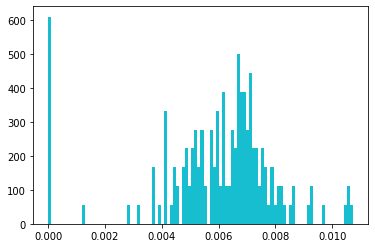

In [395]:
class ForecastingPipeline():
    def __init__(self, auto_arima):
        #TODO: make gamma a learnable parameter
        self.gamma = 10
        #significance level/threshold to compare pvalue of suspicious peaks to
        self.alpha = 0.25
        #represents the last n terms that we will use to compute an ewma when determining suspicious peaks
        self.delta = 8
        #represents beta in ewma - will determine the size of the moving window average we determine
        #for now, size of window =1/(1-0.6) which is 2.5
        self.beta = 0.9
        #represents the step taken towards exwa value
        self.mu = 0.2
        self.prophet_model = ProphetTimeStep()
        self.stat_sig_test = SignificanceTest()
        self.auto_arima = auto_arima
        self.predictions = np.array([])
        self.num_correct = 0
    
    #adjusts auto_arima prediction by making a proportional step in direction of prophet_pred and evaluates pvalue
    #size of step depends on confidence interval of prophet - if prophet is very confident of a prediction (meaning 
    #the gap between yhat_lower/upper is quite small), then a large is step is taken and vice versa    
    def make_adjustment(self, prophet_preds, auto_arima_pred, pvalue, stats_sig_test, sequence):
        #inverse the log(x+1) initally applied on the data
        sequence = list(map(lambda x: np.exp(x) + 1, sequence))
        print(sequence)
        #compute exponential moving average over last handful of terms to capture rate of change (potentially result
        #or build up of a suscpicious spike)
        exma_seq = self.stat_sig_test.ewma(sequence, self.beta)
        print("p-value: {0} adjustment: {1}".format(pvalue, exma_seq))
        rate_to_increment = self.mu*(1 - pvalue) if pvalue < self.alpha else 1/6
        for i in range(len(prophet_preds)):
            proportion = self.gamma/(prophet_preds.iloc[i]["yhat_upper"]-prophet_preds.iloc[i]["yhat_lower"])
            prophet_pred = prophet_preds.iloc[i]["yhat"]
            difference = prophet_pred - auto_arima_pred[i]
#             auto_arima_pred[i] += difference*proportion + (rate_to_increment*exma_seq)
            auto_arima_pred[i] = (2/3)*(auto_arima_pred[i]) + (1/6)*prophet_pred + rate_to_increment*exma_seq
        return auto_arima_pred
    
    
    #predict in waves of 2 e.g. predict at timestep t, t+1,  then update data to from the newly observed values
    # (i.e. actual ground truth labels at previous 4 timesteps) predict at t+2, t+3 and so on

    #Before we output our final prediction, we will make a step that is inversely proportional to yhat_upper -  
    #yhat_lower confidence interval provided by the prophet model. This means if prophet outputs a prediction that 
    #it's very confident about (meaning the confidence range is low), we will make a large step in the direction of 
    #yhat
    def fit_and_predict(self, test_data, month_data_prophet):
        self.num_correct = 0
        self.predictions = np.array([])
        for i in range(0,len(test_data),2):
            prophet_preds = self.prophet_model.predict_prophet(month_data_prophet, separation+i)
            seq_up_to_point = month_data_prophet[:separation+i]["y"].values
            pvalue = self.stat_sig_test.return_pvalue(seq_up_to_point)
            preds = self.auto_arima.model.predict(n_periods=2)
            #make a corresponding adjustment
            preds = self.make_adjustment(prophet_preds, preds, pvalue, stat_sig_test, seq_up_to_point[-delta:])
            self.predictions = np.append(self.predictions, preds)
            obs = test_data[i:i+2]
            array = list(range(2))
            correct_states = test_states.loc[i:i+2].values
            #update pipline so that model predicts from newly observed value
            self.auto_arima.model.update(obs, maxiter=10)
            correct_array = list(map(lambda x: compare_predicted_state_to_ground_truth(preds[x], correct_states[x]), 
                                     array))
            self.num_correct += sum(correct_array)
            print("")
            print('>Predicted={0}, Expected={1}'.format(preds, obs))
        accuracy = self.num_correct/len(test_data)
        print("Accuracy: %.3f" % accuracy)
        return accuracy
    
    def return_errors(self, test_data):
        print("MAE: ", mean_absolute_error(test_data, self.predictions))
        print("RMSE: ", np.power(mean_squared_error(test_data, self.predictions), 0.5))
        
    #define function below which will be used by the Bayesian optimization algorithm
    def black_box_function(self, mu, delta, gamma, beta, alpha):
        self.mu = mu
        self.delta = delta
        self.gamma = gamma
        self.beta = beta
        self.alpha = alpha
        return self.fit_and_predict(test_data, month_data_burkina_prophet)
    
    def find_optimal_parameters(self):
        # Bounded region of parameter space
        pbounds = {'mu': (0, 1), 'delta': (2, 16), 'gamma': (1, 100), 'beta':(0.1, 0.95), 'alpha':(0, 0.4)}
        optimizer = BayesianOptimization(
            f=self.black_box_function,
            pbounds=pbounds,
            verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
            random_state=1,
        )
        
        optimizer.maximize(
            init_points=2,
            n_iter=3,
        )
        print(optimizer.max)


pipeline = ForecastingPipeline(auto_arima)
# pipeline.fit_and_predict(test_data, month_data_burkina_prophet)
pipeline.find_optimal_parameters()


TODO:
1. Build cross-validation in prophet to find best parameters before fitting
2. Create some optimization function for ForecastingPipeline or build a network that finds best hyperparameters (either through grid search or something else)
3. Compute some performance metrics besides classification one we have been using e.g. MSE (mean-squared error), RSME (root mean squared error) and MAPE (mean absolute percentage error)
4. Right now, just making adjustments based on prophet and hypothesis test - experiment with other techniques like weighted average

**********

A quick note on exponentially moving averages, given $y_{t}$, an exponential moving average is defined as :

$y_{t}$ = $\beta$$y_{t-1}$ + (1-$\beta$)$\theta_{t}$

$\beta$ is a hyperparameter which can be interpreted as taking the average of 1/(1-$\beta$) previous timesteps. Therefore the closer $\beta$ is to 1, the more values it averages over, e.g. if $\beta$ = 0.5, then equivalent of taking an exponentially moving average over the two previous timesteps.

In the context of using this to help determine and make predict suspicious peak, using a large value of $\beta$ will mean the reuslt will adapt more slowly, thus if we want to pick up early on a sudden suspicious spike, a smaller $\beta$ will probably be more appropriate. The problem with using a smaller value of $\beta$ however will be our predictions may become more susceptible to outliers/more noisy.

Since we will only be taking a weighted average over the last couple of datapoints (around 3 or 4)- we will apply bias correction to make our estimates more accurate.

*************

Which test metric to use?
1. RMSE will penalize large differences - may be a good way to check whether we predict a spike or not (prefers smaller numbers)
2. MAE (Mean Absolute Error) - also prefers smaller numbers
3. MBE (Mean Bias Error) - similar to MAE but don't have absolute difference thus sign can give us information about whether we over/underestimate 
4. MAPE (Mean Absolute Percentage Error) looks at ratio - may give better holistic idea of how model is performing, especially across different countries which will have varying number of cases e.g. Burkina Faso tends to have a lot while Mauritania tends to have very little. However this also does not perform well when values are close to 0.

Idea: for each component in our forecasting pipeline, can choose to evalute a difference performance metric based on what behavior we desire to obtain from that component. For example, our significance test is designed to detect spikes, thus a good metric to optimize for would be RMSE since we want to reduce error on large spikes. 

Can use MAPE for prophet since we want to capture the seasonal trend and in general make "solid" predictions on year-round data as opposed to only detecting spikes.

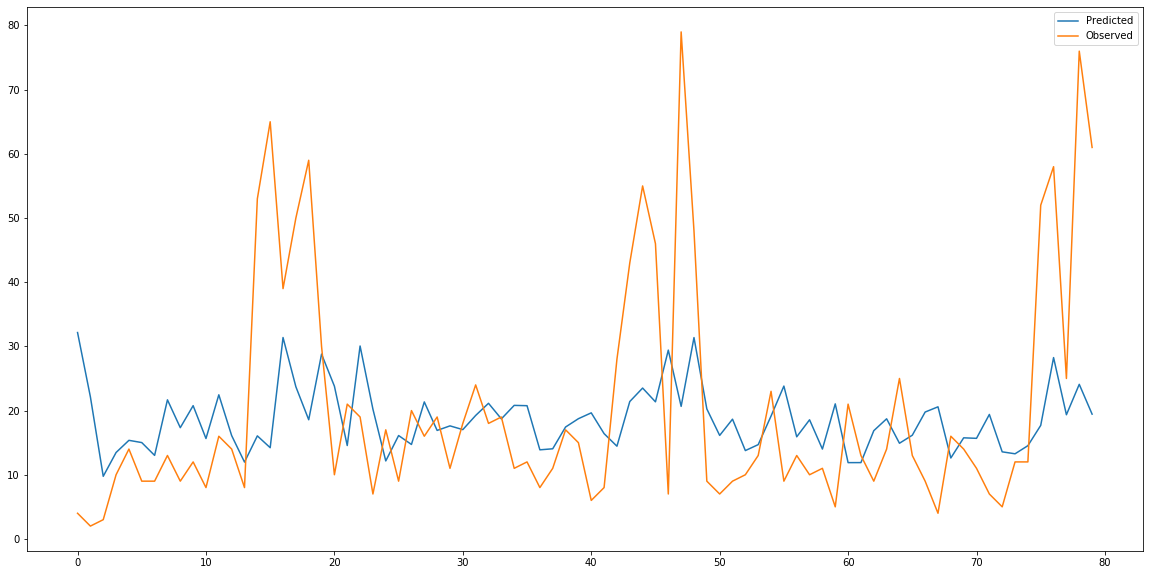

In [396]:
fig, ax = plt.subplots(1, 1, figsize=(20,10))
ax.plot(pipeline.predictions, label="Predicted")
ax.plot(test_data, label="Observed")
ax.legend()

In [409]:
month_data_epy = month_data_burkina_prophet.copy()
month_data_epy = month_data_epy.set_index('ds')

In [411]:
month_data_epy = month_data_epy.rename(columns={'y': 'n_cases'})
print(month_data_epy)

             n_cases
ds                  
2006-01-31  3.713572
2006-02-28  4.812184
2006-03-31  5.866468
2006-04-30  5.209486
2006-05-31  0.000000
...              ...
2019-08-31  4.077537
2019-09-30  3.258097
2019-10-31  4.343805
2019-11-30  0.000000
2019-12-31  3.806662

[168 rows x 1 columns]


In [414]:
epysurv.models.timeseries.convert_interface.Bayes.fit(month_data_epy)

NameError: name 'epysurv' is not defined